In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Memoria GPU configurada correctamente


In [3]:
#1. Librerías y configuración inicial
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow_addons as tfa

from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
#2. Funciones de carga
BASE_IMG = r"../data/processed"
BASE_MASK = r"../data/masks_manual_bin"


def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    return img


def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask


def load_pair(img_path, mask_path):
    img = load_image(img_path.numpy().decode())
    mask = load_mask(mask_path.numpy().decode())
    return img, mask


def tf_wrapper(img_path, mask_path):
    img, mask = tf.py_function(
        load_pair,
        [img_path, mask_path],
        [tf.float32, tf.float32]
    )
    img.set_shape([384,384,1])
    mask.set_shape([384,384,1])
    return img, mask


def df_to_dataset(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["img"].values, df["mask"].values)
    )
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(500, reshuffle_each_iteration=True)
    ds = ds.batch(4).prefetch(tf.data.AUTOTUNE)
    return ds

In [5]:
#3. Cargar splits
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds = df_to_dataset(val_df, shuffle=False)

In [6]:
#4. Losses y métricas
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1 - dice_coef(y_true, y_pred))

In [7]:
#5. Implementación de U-NET++
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def upsample(x):
    return layers.UpSampling2D((2,2), interpolation="bilinear")(x)


def UNetPP(input_shape=(384,384,1), filters=[32,64,128,256,512]):
    inputs = layers.Input(input_shape)

    # -------- ENCODER --------
    x0_0 = conv_block(inputs, filters[0])
    x1_0 = conv_block(layers.MaxPool2D()(x0_0), filters[1])
    x2_0 = conv_block(layers.MaxPool2D()(x1_0), filters[2])
    x3_0 = conv_block(layers.MaxPool2D()(x2_0), filters[3])
    x4_0 = conv_block(layers.MaxPool2D()(x3_0), filters[4])

    # -------- DECODER (Nested connections) --------
    x0_1 = conv_block(tf.concat([x0_0, upsample(x1_0)], axis=-1), filters[0])
    x1_1 = conv_block(tf.concat([x1_0, upsample(x2_0)], axis=-1), filters[1])
    x2_1 = conv_block(tf.concat([x2_0, upsample(x3_0)], axis=-1), filters[2])
    x3_1 = conv_block(tf.concat([x3_0, upsample(x4_0)], axis=-1), filters[3])

    x0_2 = conv_block(tf.concat([x0_0, x0_1, upsample(x1_1)], axis=-1), filters[0])
    x1_2 = conv_block(tf.concat([x1_0, x1_1, upsample(x2_1)], axis=-1), filters[1])
    x2_2 = conv_block(tf.concat([x2_0, x2_1, upsample(x3_1)], axis=-1), filters[2])

    x0_3 = conv_block(tf.concat([x0_0, x0_1, x0_2, upsample(x1_2)], axis=-1), filters[0])
    x1_3 = conv_block(tf.concat([x1_0, x1_1, x1_2, upsample(x2_2)], axis=-1), filters[1])

    x0_4 = conv_block(tf.concat([x0_0, x0_1, x0_2, x0_3, upsample(x1_3)], axis=-1), filters[0])

    # -------- OUTPUT --------
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x0_4)

    model = models.Model(inputs, outputs)
    return model

In [8]:
#6. Crear y compilar modelo
model = UNetPP()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
#7. Callbacks
callbacks = [
    ModelCheckpoint("unetpp_best.h5", save_best_only=True, monitor="val_loss", mode="min"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
]

In [10]:
#8. Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

model.save("unetpp_final.h5")

Epoch 1/60
80/80 [==============================] - 333s 828ms/step - loss: 0.8979 - dice_coef: 0.4663 - val_loss: 1.3863 - val_dice_coef: 0.2067 - lr: 1.0000e-04
Epoch 2/60
80/80 [==============================] - 64s 785ms/step - loss: 0.6319 - dice_coef: 0.5866 - val_loss: 1.3738 - val_dice_coef: 0.2097 - lr: 1.0000e-04
Epoch 3/60
80/80 [==============================] - 64s 777ms/step - loss: 0.5533 - dice_coef: 0.6313 - val_loss: 1.2796 - val_dice_coef: 0.1440 - lr: 1.0000e-04
Epoch 4/60
80/80 [==============================] - 64s 779ms/step - loss: 0.5026 - dice_coef: 0.6609 - val_loss: 1.2726 - val_dice_coef: 0.1189 - lr: 1.0000e-04
Epoch 5/60
80/80 [==============================] - 63s 775ms/step - loss: 0.4620 - dice_coef: 0.6859 - val_loss: 1.2947 - val_dice_coef: 0.1049 - lr: 1.0000e-04
Epoch 6/60
80/80 [==============================] - 64s 784ms/step - loss: 0.4155 - dice_coef: 0.7133 - val_loss: 1.2257 - val_dice_coef: 0.1483 - lr: 1.0000e-04
Epoch 7/60
80/80 [=========

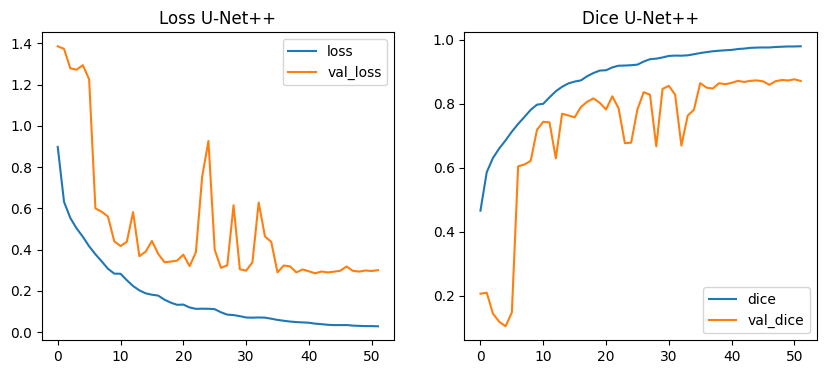

In [11]:
#9. Gráfica de métricas

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss U-Net++")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["dice_coef"], label="dice")
plt.plot(history.history["val_dice_coef"], label="val_dice")
plt.title("Dice U-Net++")
plt.legend()

plt.show()